In [2]:
from prody import *

from matplotlib.pylab import *
ion()

In [46]:
import pandas as pd

In [3]:
# Gene
gene = "PTPN11"

# Dictionary of PDB IDs for each gene
pdb_ids = {
    "PTPN11": "2SHP", 
}

enm_cutoffs = {"2SHP": "", #and resnum 2 to 216
               }



In [4]:
# Apply chain and cutoff selection
pdb_id = pdb_ids.get(gene)
structure = parsePDB(pdb_id)
calphas = structure.select(f"calpha and chain A {enm_cutoffs[pdb_id]}")
calphas

@> PDB file is found in working directory (pdb2shp.pdb).
@> 12167 atoms and 1 coordinate set(s) were parsed in 0.25s.


<Selection: 'calpha and chain A ' from 2SHP (491 atoms)>

In [5]:
calphas.getResnames()  
#calphas.getResnums()[:10]   # first 10 residue numbers


array(['LYS', 'SER', 'ARG', 'ARG', 'TRP', 'PHE', 'HIS', 'PRO', 'ASN',
       'ILE', 'THR', 'GLY', 'VAL', 'GLU', 'ALA', 'GLU', 'ASN', 'LEU',
       'LEU', 'LEU', 'THR', 'ARG', 'GLY', 'VAL', 'ASP', 'GLY', 'SER',
       'PHE', 'LEU', 'ALA', 'ARG', 'PRO', 'SER', 'LYS', 'SER', 'ASN',
       'PRO', 'GLY', 'ASP', 'LEU', 'THR', 'LEU', 'SER', 'VAL', 'ARG',
       'ARG', 'ASN', 'GLY', 'ALA', 'VAL', 'THR', 'HIS', 'ILE', 'LYS',
       'ILE', 'GLN', 'ASN', 'THR', 'GLY', 'ASP', 'TYR', 'TYR', 'ASP',
       'LEU', 'TYR', 'GLY', 'GLY', 'GLU', 'LYS', 'PHE', 'ALA', 'THR',
       'LEU', 'ALA', 'GLU', 'LEU', 'VAL', 'GLN', 'TYR', 'TYR', 'MET',
       'GLU', 'HIS', 'HIS', 'GLY', 'GLN', 'LEU', 'LYS', 'GLU', 'LYS',
       'ASN', 'GLY', 'ASP', 'VAL', 'ILE', 'GLU', 'LEU', 'LYS', 'TYR',
       'PRO', 'LEU', 'ASN', 'CYS', 'ALA', 'ASP', 'PRO', 'THR', 'SER',
       'GLU', 'ARG', 'TRP', 'PHE', 'HIS', 'GLY', 'HIS', 'LEU', 'SER',
       'GLY', 'LYS', 'GLU', 'ALA', 'GLU', 'LYS', 'LEU', 'LEU', 'THR',
       'GLU', 'LYS',

In [6]:
# Build GNM and calculate modes
gnm = GNM(pdb_id)
gnm.buildKirchhoff(calphas)
n_calpha = calphas.numAtoms()
gnm.calcModes(n_calpha - 1)  # internal modes are n-1. 1 is trivial (0, translation + rotation)


@> Kirchhoff was built in 0.03s.
@> 490 modes were calculated in 0.33s.


In [7]:
slowest_mode = gnm[0]


In [8]:
resnums = calphas.getResnums()
mode0_hinges = calcHinges(gnm[0])
resnums[mode0_hinges]

array([  3,  13,  18,  20,  22,  24,  29,  32, 100, 221, 250, 251, 255,
       257])

In [18]:
# Extract PDB residue numbers for all selected Cα atoms
resnums = calphas.getResnums()

# Get hinge indices from mode 0
mode0_hinges = calcHinges(gnm[0])

# Map hinge indices to actual PDB residue numbers
pdb_positions = resnums[mode0_hinges]

# Build dataframe
df = pd.DataFrame({
    "pdb_residue": pdb_positions,
    "type": ["Hinge"] * len(pdb_positions)
})

# Save to CSV
df.to_csv(f"{gene}_prodyhinges.csv", index=False)


In [54]:
df

,pdb_start,type
0,3,hinge
1,13,hinge
2,18,hinge
3,20,hinge
4,22,hinge
5,24,hinge
6,29,hinge
7,32,hinge
8,100,hinge
9,221,hinge


In [19]:
import numpy as np
import pandas as pd
from prody import *

# Assuming you already have:
# calphas = pdb.select('name CA')
# gnm = GNM('GNM'); gnm.buildHessian(calphas); gnm.calcModes()

resnums = calphas.getResnums()
mode0_hinges = calcHinges(gnm[0])
mode_vals = gnm[0].getArray()  # per-residue scalar mode values

# Robust sign change check: four consecutive negative then four consecutive positive
def has_robust_sign_change(idx, mode_array):
    # ensure indices are within bounds
    if idx < 4 or idx > len(mode_array) - 5:
        return False
    # previous four residues
    prev4 = mode_array[idx-4:idx]
    # next four residues
    next4 = mode_array[idx+1:idx+5]
    # check if all prev4 negative and all next4 positive
    if np.all(prev4 < 0) and np.all(next4 > 0):
        return True
    # check if all prev4 positive and all next4 negative
    if np.all(prev4 > 0) and np.all(next4 < 0):
        return True
    return False

# Filter hinges using the robust sign-change criterion
hinges_with_sign_change = [idx for idx in mode0_hinges if has_robust_sign_change(idx, mode_vals)]

# Map hinge indices to PDB residue numbers
pdb_positions = resnums[hinges_with_sign_change]

# Build dataframe
df = pd.DataFrame({
    "pdb_residue": pdb_positions,
    "type": ["Hinge"] * len(pdb_positions)
})

# Save to CSV
df.to_csv(f"{gene}_prodyhinges.csv", index=False)


In [17]:
df

,pdb_start,type
0,100,Hinge
1,221,Hinge


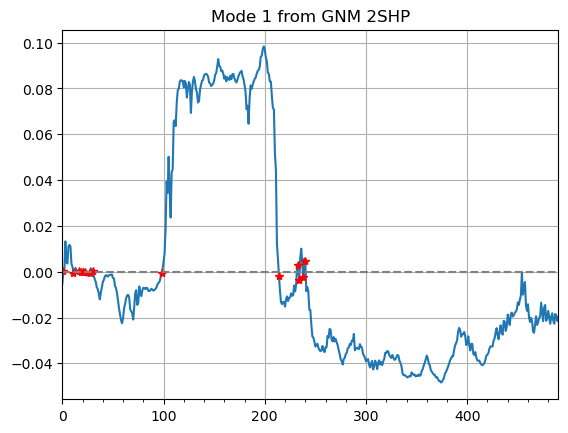

In [42]:
showMode(gnm[0], hinges=True, zero=True);

grid();

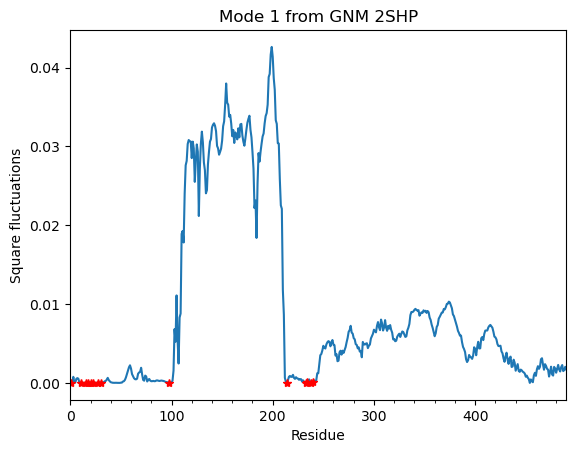

In [28]:
showSqFlucts(gnm[0], hinges=True);

In [43]:
for i, atom in enumerate(calphas):
    print(i, atom.getChid(), atom.getResnum(), atom.getResname())


0 A 2 LYS
1 A 3 SER
2 A 4 ARG
3 A 5 ARG
4 A 6 TRP
5 A 7 PHE
6 A 8 HIS
7 A 9 PRO
8 A 10 ASN
9 A 11 ILE
10 A 12 THR
11 A 13 GLY
12 A 14 VAL
13 A 15 GLU
14 A 16 ALA
15 A 17 GLU
16 A 18 ASN
17 A 19 LEU
18 A 20 LEU
19 A 21 LEU
20 A 22 THR
21 A 23 ARG
22 A 24 GLY
23 A 25 VAL
24 A 26 ASP
25 A 27 GLY
26 A 28 SER
27 A 29 PHE
28 A 30 LEU
29 A 31 ALA
30 A 32 ARG
31 A 33 PRO
32 A 34 SER
33 A 35 LYS
34 A 36 SER
35 A 37 ASN
36 A 38 PRO
37 A 39 GLY
38 A 40 ASP
39 A 41 LEU
40 A 42 THR
41 A 43 LEU
42 A 44 SER
43 A 45 VAL
44 A 46 ARG
45 A 47 ARG
46 A 48 ASN
47 A 49 GLY
48 A 50 ALA
49 A 51 VAL
50 A 52 THR
51 A 53 HIS
52 A 54 ILE
53 A 55 LYS
54 A 56 ILE
55 A 57 GLN
56 A 58 ASN
57 A 59 THR
58 A 60 GLY
59 A 61 ASP
60 A 62 TYR
61 A 63 TYR
62 A 64 ASP
63 A 65 LEU
64 A 66 TYR
65 A 67 GLY
66 A 68 GLY
67 A 69 GLU
68 A 70 LYS
69 A 71 PHE
70 A 72 ALA
71 A 73 THR
72 A 74 LEU
73 A 75 ALA
74 A 76 GLU
75 A 77 LEU
76 A 78 VAL
77 A 79 GLN
78 A 80 TYR
79 A 81 TYR
80 A 82 MET
81 A 83 GLU
82 A 84 HIS
83 A 85 HIS
84 A 86 GL

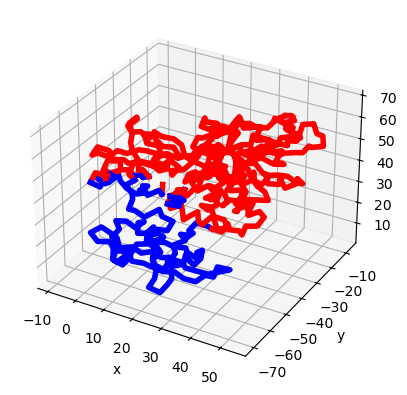

In [57]:
showProtein(calphas, mode=gnm[0]);